In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import json
from os.path import expanduser

In [2]:
BASE_RESULTS_DIR = '/media/data-4t-a/results-P3856'

In [3]:
experiment_name = 'P3856'
feature_detection_method = 'pasef'

IDENTIFICATIONS_WITH_CS_DIR = '{}/P3856_YHE211_1_Slot1-1_1_5104-cs-true-fmdw-true-2021-09-01-09-49-06/identifications-pasef'.format(BASE_RESULTS_DIR)
IDENTIFICATIONS_WITH_CS_FILE = '{}/exp-{}-identifications-{}-recalibrated.feather'.format(IDENTIFICATIONS_WITH_CS_DIR, experiment_name, feature_detection_method)

In [4]:
IDENTIFICATIONS_WITH_CS_FILE

'/media/data-4t-a/results-P3856/P3856_YHE211_1_Slot1-1_1_5104-cs-true-fmdw-true-2021-09-01-09-49-06/identifications-pasef/exp-P3856-identifications-pasef-recalibrated.feather'

In [5]:
MAXIMUM_Q_VALUE = 0.01

#### identifications with correction for saturation

In [6]:
# load the identifications that had saturated points in the mono
identifications_with_cs_df = pd.read_feather(IDENTIFICATIONS_WITH_CS_FILE)
identifications_with_cs_df = identifications_with_cs_df[(identifications_with_cs_df['percolator q-value'] <= MAXIMUM_Q_VALUE)]

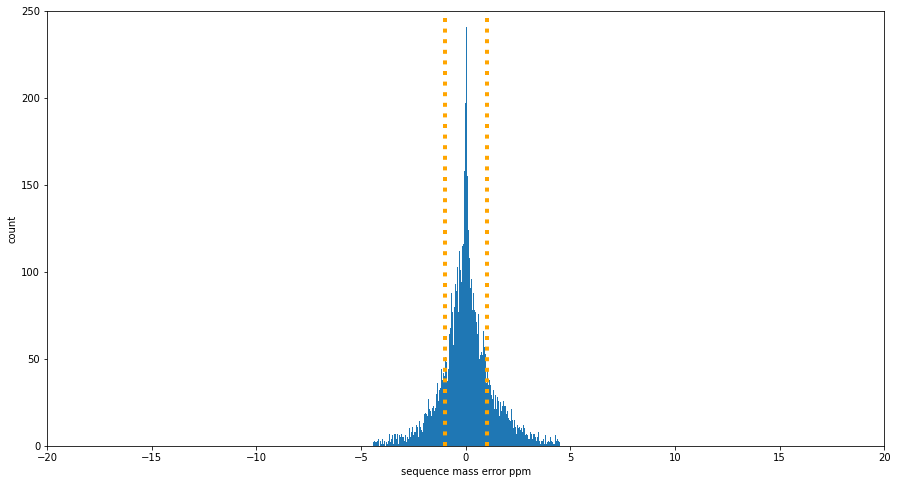

In [7]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
# plt.title('Peptide sequence mass error distribution (max q-value {})\nwith correction for saturation, std dev {}'.format(MAXIMUM_Q_VALUE, round(identifications_with_cs_df.mass_accuracy_ppm.std(),2)))

bins = 300
hist, bins, _ = plt.hist(identifications_with_cs_df.mass_accuracy_ppm, bins=bins)
plt.xlabel('sequence mass error ppm')
plt.ylabel('count')

plt.xlim((-20,20))
plt.ylim((0,250))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

In [8]:
'Peptide sequence mass error distribution (max q-value {})\nwith correction for saturation, std dev {}'.format(MAXIMUM_Q_VALUE, round(identifications_with_cs_df.mass_accuracy_ppm.std(),2))

'Peptide sequence mass error distribution (max q-value 0.01)\nwith correction for saturation, std dev 1.27'

#### identifications without correction for saturation

In [9]:
IDENTIFICATIONS_WITHOUT_CS_DIR = '{}/P3856_YHE211_1_Slot1-1_1_5104-cs-false-fmdw-true-2021-09-01-11-06-43/identifications-pasef'.format(BASE_RESULTS_DIR)
IDENTIFICATIONS_WITHOUT_CS_FILE = '{}/exp-{}-identifications-{}-recalibrated.feather'.format(IDENTIFICATIONS_WITHOUT_CS_DIR, experiment_name, feature_detection_method)

In [10]:
# load the identifications that had saturated points in the mono
identifications_without_cs_df = pd.read_feather(IDENTIFICATIONS_WITHOUT_CS_FILE)
identifications_without_cs_df = identifications_without_cs_df[(identifications_without_cs_df['percolator q-value'] <= MAXIMUM_Q_VALUE)]

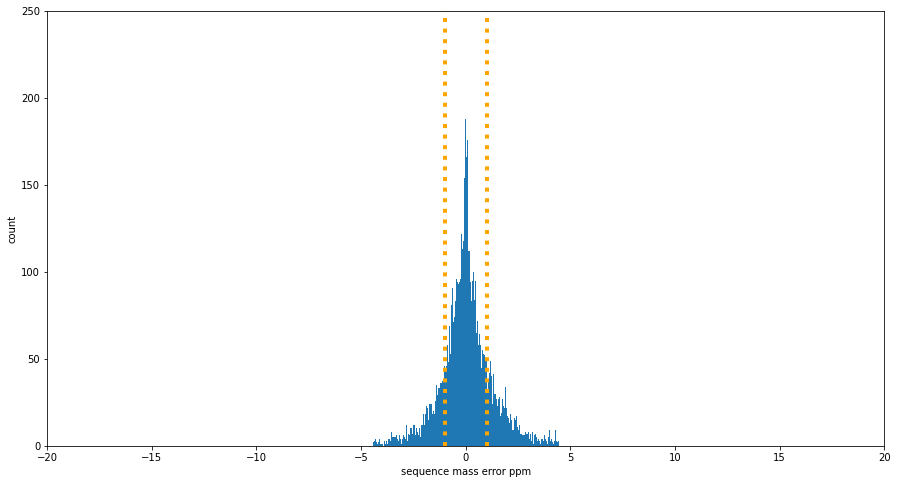

In [11]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
# plt.title('Peptide sequence mass error distribution (max q-value {})\nwithout correction for saturation, std dev {}'.format(MAXIMUM_Q_VALUE, round(identifications_without_cs_df.mass_accuracy_ppm.std(),2)))

bins = 300
hist, bins, _ = plt.hist(identifications_without_cs_df.mass_accuracy_ppm, bins=bins)
plt.xlabel('sequence mass error ppm')
plt.ylabel('count')

plt.xlim((-20,20))
plt.ylim((0,250))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

In [12]:
'Peptide sequence mass error distribution (max q-value {})\nwithout correction for saturation, std dev {}'.format(MAXIMUM_Q_VALUE, round(identifications_without_cs_df.mass_accuracy_ppm.std(),2))

'Peptide sequence mass error distribution (max q-value 0.01)\nwithout correction for saturation, std dev 1.28'

#### unique identifications found with and without saturation correction

In [13]:
affected_idents_df = identifications_with_cs_df[(identifications_with_cs_df.mono_intensity_adjustment_outcome == 'monoisotopic_saturated_adjusted')]

In [14]:
sequences_l = []
for group_name,group_df in affected_idents_df.groupby(['sequence','charge'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    percolator_score = group_df['percolator score'].max()
    q_value = group_df['percolator q-value'].min()
    mass_accuracy_ppm = group_df.mass_accuracy_ppm.min()
    mass_accuracy_ppm_abs = abs(group_df.mass_accuracy_ppm).min()
    sequences_l.append({'sequence':sequence, 'charge':charge, 'score':percolator_score, 'q_value':q_value, 'mass_accuracy_ppm':mass_accuracy_ppm, 'mass_accuracy_ppm_abs':mass_accuracy_ppm_abs})
sequences_with_cs_df = pd.DataFrame(sequences_l)

In [15]:
sequences_l = []
for group_name,group_df in identifications_without_cs_df.groupby(['sequence','charge'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    percolator_score = group_df['percolator score'].max()
    q_value = group_df['percolator q-value'].min()
    mass_accuracy_ppm = group_df.mass_accuracy_ppm.min()
    mass_accuracy_ppm_abs = abs(group_df.mass_accuracy_ppm).min()
    sequences_l.append({'sequence':sequence, 'charge':charge, 'score':percolator_score, 'q_value':q_value, 'mass_accuracy_ppm':mass_accuracy_ppm, 'mass_accuracy_ppm_abs':mass_accuracy_ppm_abs})
sequences_without_cs_df = pd.DataFrame(sequences_l)

In [16]:
combined_df = pd.merge(sequences_with_cs_df, sequences_without_cs_df, how='inner', left_on=['sequence','charge'], right_on=['sequence','charge'], suffixes=['_with_cs','_without_cs'])


In [17]:
combined_df.sample(n=5)

,sequence,charge,score_with_cs,q_value_with_cs,mass_accuracy_ppm_with_cs,mass_accuracy_ppm_abs_with_cs,score_without_cs,q_value_without_cs,mass_accuracy_ppm_without_cs,mass_accuracy_ppm_abs_without_cs
21,ARFEELNADLFR,2,0.579531,0.000158,0.071473,0.071473,0.610401,0.000159,0.075258,0.075258
353,YASICQQNGIVPIVEPEILPDGDHDLK,3,1.695404,0.000158,0.339869,0.339869,1.645823,0.000159,0.238205,0.238205
99,GFAFVTFDDHDTVDK,2,1.353625,0.000158,-0.378127,0.378127,1.314659,0.000159,-0.336844,0.336844
339,VTIAQGGVLPNIQAVLLPK,2,1.140225,0.000158,0.018775,0.018775,1.064723,0.000159,-0.091358,0.091358
66,EILVGDVGQTVDDPYATFVK,2,1.533214,0.000158,0.920212,0.920212,1.476347,0.000159,0.770329,0.770329


In [18]:
combined_df['score_improvement_with_cs'] = combined_df.score_with_cs - combined_df.score_without_cs
mean_score_improvement = combined_df.score_improvement_with_cs.mean()
mean_score_improvement

0.01931681770666667

In [19]:
combined_df['mass_accuracy_improvement_with_cs'] = combined_df.mass_accuracy_ppm_abs_with_cs - combined_df.mass_accuracy_ppm_abs_without_cs
mean_mass_accuracy_improvement = combined_df.mass_accuracy_improvement_with_cs.mean()
mean_mass_accuracy_improvement

0.06415444515364513

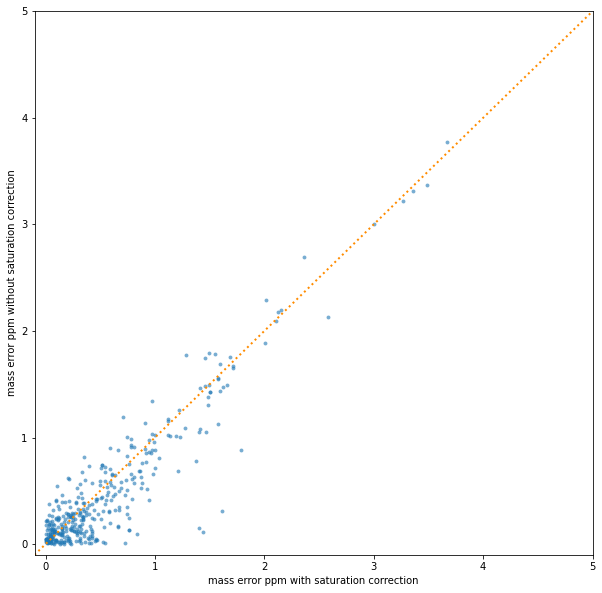

In [20]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
# plt.title('')

ax.scatter(combined_df.mass_accuracy_ppm_abs_with_cs, combined_df.mass_accuracy_ppm_abs_without_cs, marker='o', lw=0, s=15, alpha=0.6)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=2, color='darkorange')

plt.xlim((-0.1,5.0))
plt.ylim((-0.1,5.0))

plt.xlabel('mass error ppm with saturation correction')
plt.ylabel('mass error ppm without saturation correction')

plt.show()

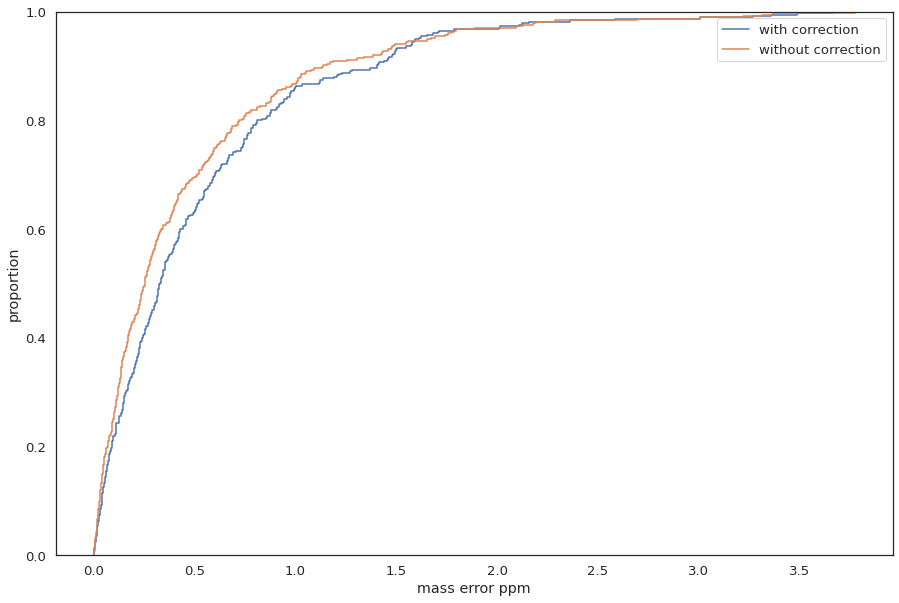

In [39]:
import seaborn as sns

plt.figure(figsize=(15, 10))

sns.set(font_scale = 1.2)
sns.set_style("white")

# title = 'ECDF of mass error ppm'
# plt.title(title)

ax = sns.ecdfplot(data=combined_df, x="mass_accuracy_ppm_abs_with_cs", label='with correction')
_ = sns.ecdfplot(data=combined_df, x="mass_accuracy_ppm_abs_without_cs", label='without correction')
plt.legend(loc='best')
_ = ax.set(xlabel='mass error ppm', ylabel='proportion')

/home/daryl/anaconda3/envs/py36/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/daryl/anaconda3/envs/py36/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


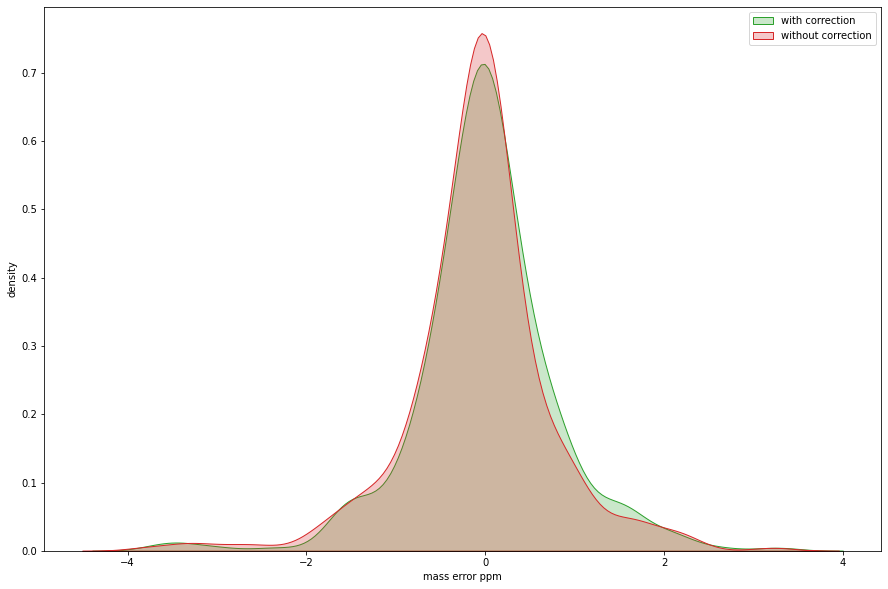

In [22]:
import seaborn as sns
plt.figure(figsize=(15, 10))

# title = 'density of the mass error ppm of identified features affected by points in saturation'
# plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(combined_df.mass_accuracy_ppm_with_cs, hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'with correction')
_ = sns.distplot(combined_df.mass_accuracy_ppm_without_cs, hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'without correction')

_ = ax.set(xlabel='mass error ppm', ylabel='density')
_ = ax.legend()

#### dynamic range comparison

In [23]:
s1 = identifications_with_cs_df.mono_intensity_adjustment_outcome.value_counts(normalize=False).rename('counts', inplace=True)
s2 = round(identifications_with_cs_df.mono_intensity_adjustment_outcome.value_counts(normalize=True)*100,1).rename('%', inplace=True)
pd.concat([s1, s2], axis=1)

,counts,%
monoisotopic_not_saturated,8206,95.4
monoisotopic_saturated_adjusted,394,4.6
no_nonsaturated_isotopes,4,0.0
could_not_calculate_phr,1,0.0


In [24]:
identifications_with_cs_df = identifications_with_cs_df.copy()
identifications_with_cs_df['intensity_log'] = np.log10(identifications_with_cs_df.feature_intensity)

identifications_without_cs_df = identifications_without_cs_df.copy()
identifications_without_cs_df['intensity_log'] = np.log10(identifications_without_cs_df.feature_intensity)

identifications_with_cs_df['method'] = 'corrected for saturation'
identifications_without_cs_df['method'] = 'not corrected for saturation'
idents_df = pd.concat([identifications_with_cs_df,identifications_without_cs_df], axis=0, sort=False)


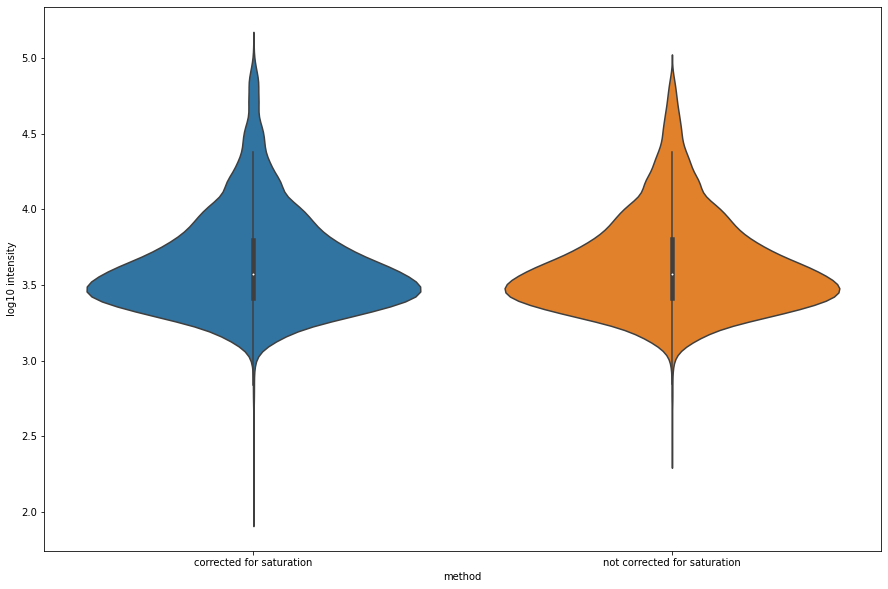

In [25]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(x=idents_df.method, y=idents_df.intensity_log)
_ = plt.ylabel("log10 intensity")
# _ = plt.title('distribution of feature intensities (in log10 scale) detected in YHE211_1, N={}'.format(len(identifications_with_cs_df)))

In [26]:
dynamic_range_with_cs = identifications_with_cs_df.intensity_log.max() - identifications_with_cs_df.intensity_log.min()
dynamic_range_without_cs = identifications_without_cs_df.intensity_log.max() - identifications_without_cs_df.intensity_log.min()
print('orders of magnitude with cs: {}, without cs: {}'.format(round(dynamic_range_with_cs,2), round(dynamic_range_without_cs,2)))

orders of magnitude with cs: 3.05, without cs: 2.52


#### for those identifications with an adjusted intensity, what would the intensity range have been without correction?

In [27]:
adj_with_cs_df = identifications_with_cs_df[identifications_with_cs_df.mono_intensity_adjustment_outcome == 'monoisotopic_saturated_adjusted']


In [28]:
adj_l = []
for row in adj_with_cs_df.itertuples():
    cs_intensity = row.intensity_with_saturation_correction if (row.intensity_with_saturation_correction > row.intensity_without_saturation_correction) else row.intensity_without_saturation_correction
    adj_l.append({'feature_intensity':cs_intensity, 'method':'corrected'})
    adj_l.append({'feature_intensity':row.intensity_without_saturation_correction, 'method':'not corrected'})
adj_df = pd.DataFrame(adj_l)
adj_df['intensity_log'] = np.log10(adj_df.feature_intensity)

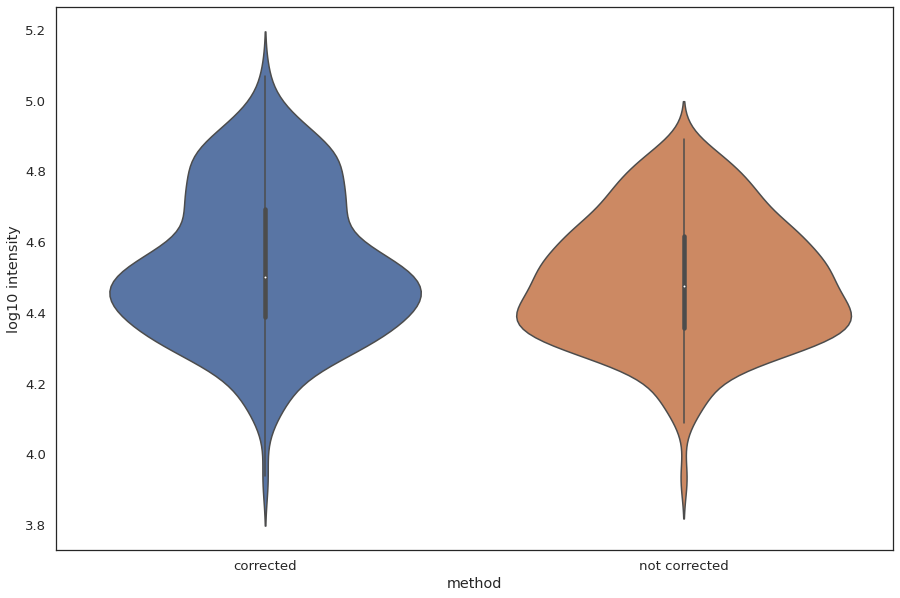

In [36]:
plt.figure(figsize=(15,10))
sns.set(font_scale = 1.2)
sns.set_style("white")
ax = sns.violinplot(x=adj_df.method, y=adj_df.intensity_log)
_ = plt.ylabel("log10 intensity")
# _ = plt.title('distribution of intensities for features with the monoisotopic peak in saturation (in log10 scale) detected in YHE211_1, N={}'.format(len(adj_with_cs_df)))

In [30]:
with_cs_df = adj_df[(adj_df.method == 'corrected')]
without_cs_df = adj_df[(adj_df.method == 'not corrected')]

dynamic_range_with_cs = with_cs_df.intensity_log.max() - with_cs_df.intensity_log.min()
dynamic_range_without_cs = without_cs_df.intensity_log.max() - without_cs_df.intensity_log.min()
print('orders of magnitude with cs: {}, without cs: {}'.format(round(dynamic_range_with_cs,2), round(dynamic_range_without_cs,2)))

orders of magnitude with cs: 1.14, without cs: 0.97
